# Análise da Implementação



### Imports:

In [1]:
from typing import List, Any, Tuple
from classifier.my_adaboost import MyAdaboostClassifier
from sklearn.ensemble import AdaBoostClassifier
import csv
import numpy as np
import matplotlib.pyplot as plt

### Useful Functions:

In [2]:
def get_tic_tac_toe_data() -> Tuple[list, list]:
    """
        Funcao para ler o arquivo de entrada e retornar os dados em forma
        de listas numericas
    """
    
    def category_converter(item):
        if item == 'x' or item == 'positive':
            return 1
        if item == 'o' or item == 'negative':
            return -1
        if item == 'b':
            return 0
        raise ValueError

    feature_values, label_values = list(), list()
    with open('tic-tac-toe.data', newline='') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            feature_values.append(np.array([category_converter(item) for item in row[:-1]]))
            label_values.append(category_converter(row[-1]))
            
    return feature_values, label_values


def create_k_partitions(features: list, labels: list, k=5, random_seed=42) -> Tuple[List[list], List[list]]:
    """
        Funcao para criar k particoes dos dados de entrada para realizar
        a validacao cruzada
    """
    
    np.random.seed(random_seed)
    partition_size = len(features) // k
    
    features_partitions = list()
    labels_partitions = list()
    for _ in range(k):
        f_partition = list()
        l_partition = list()
        while len(f_partition) < partition_size:
            item_idx = np.random.randint(len(features))
            f_partition.append(features.pop(item_idx))
            l_partition.append(labels.pop(item_idx))
        features_partitions.append(f_partition)
        labels_partitions.append(l_partition)

    return features_partitions, labels_partitions


def cross_validation_score(model: Any, features_partitions: List[list], labels_partitions: List[list]) -> Tuple[float, float]:
    """
        Funcao para calcular a taxa de acertos do classificador com seu 
        respectivo desvio padrao por meio da validacao cruzada
    """
    
    partitions_size = len(features_partitions)
    partitions_accuracy_score = []
    for i in range(partitions_size):
        features_to_test = features_partitions[i]
        labels_to_test = labels_partitions[i]
        features_to_train = list()
        labels_to_train = list()
        for j in range(partitions_size):
            if i != j:
                labels_to_train.extend(labels_partitions[j])
                features_to_train.extend(features_partitions[j])
        model.fit(features_to_test, np.array(labels_to_test))
        partitions_accuracy_score.append(model.score(features_to_train, np.array(labels_to_train)))
    partitions_accuracy_score = np.array(partitions_accuracy_score)
    
    return partitions_accuracy_score.mean(), np.sqrt(partitions_accuracy_score.var())

### Preparing Data

In [3]:
features, labels = get_tic_tac_toe_data()
features_partitions, labels_partitions = create_k_partitions(features, labels, k=5)

### Experiments:

#### 1 - Número de estimadores

A predição de um classificador do tipo boosting é feita a partir de uma média ponderada das classificações de um conjunto de classificadores fracos. Logo, como por definição um classificador fraco é aquele que não é muito melhor do que um cara-coroa, a quantidade de estimadores que utilizamos para fazer a média faz muita diferença.

No experimento a baixo alternarmos o número de estimadores que é utilizado nos classificadores, tanto na minha implementação (MyAdaboost) como na implementação do pacote sklerarn, e plotamos como a accuracy dos classificadores se comporta com o n_estimators. Vemos que com 1 n_estimator os Adaboost's são apenas um pouco melhor que o cara-coroa (50%), mas com o aumento de n_estimators os dois classificadores vão ficando melhores. Exatamente o que é descrito na teoria.

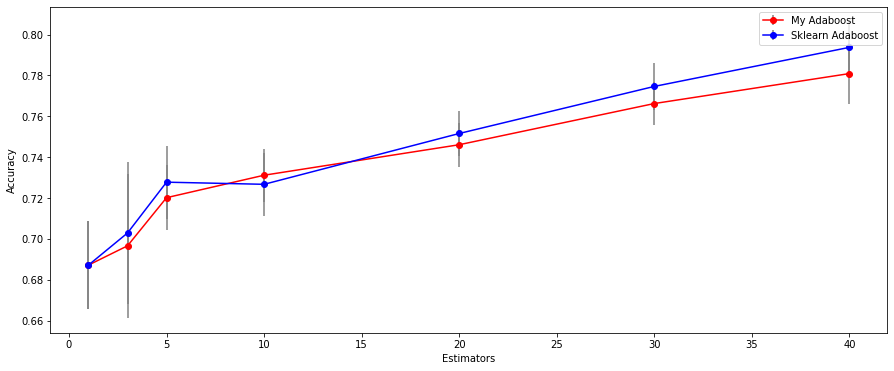

In [4]:
n_estimators_to_test = [1, 3, 5, 10, 20, 30, 40]

# Realizando o experimento para o MyAdaboost
my_adaboost_accuracy = list()
my_adaboost_error = list()
for n in n_estimators_to_test:
  accuracy, error = cross_validation_score(MyAdaboostClassifier(n_estimators=n, classifier_model='stump'),
                                           features_partitions, labels_partitions)
  my_adaboost_accuracy.append(accuracy)
  my_adaboost_error.append(error)
  
# Realizando o experimento para o ScyKit Learn Adaboost
sklearn_adaboost_accuracy = list()
sklearn_adaboost_error = list()
for n in n_estimators_to_test:
  accuracy, error = cross_validation_score(AdaBoostClassifier(n_estimators=n),
                                           features_partitions, labels_partitions)
  sklearn_adaboost_accuracy.append(accuracy)
  sklearn_adaboost_error.append(error)
  
# Plotando os resultados
plt.figure(figsize=(15, 6))
plt.errorbar(x=n_estimators_to_test, y=my_adaboost_accuracy, yerr=my_adaboost_error,
             fmt='-o', color='r', ecolor='gray', label='My Adaboost')
plt.errorbar(x=n_estimators_to_test, y=sklearn_adaboost_accuracy, yerr=sklearn_adaboost_error,
             fmt='-o', color='b', ecolor='gray',label='Sklearn Adaboost')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 2 - Diferentes Classificadores

No teste anterior eu comparei o funcionamento de dois Adaboost em relação aos n-estimators, mas havia algo de comum aos dois estimadores, ambos utilizavam como classificador fraco aqui que chamamos de stump, que nada mais é que uma árvore de decisão de apenas um corte.

Porém não necessariamente temos que utilizar esse tipo de classificador, e portanto, no próximo experimento veremos como o MyAdaboost vai se comportar ao utilizarmos outro tipo de classificador fraco. Nesse caso, optei por utilizar a regressão logística com forte regularização como opção de classificador fraco.

E assim, como se pode ver, o comportamento dos dois classificadores vão melhorando de acordo com as características já explicadas no experimento 1, mas como a regressão logística encaixou melhor no nosso dataset, tivemos que o classificador que foi baseado nele performou bem melhor o outro. O que de modo geral nos leva a afirmar que, por mais que o stump seja o classificador fraco mais utilizado nos Adaboost's, nem sempre ele va ser a melhor opção dado um certo conjunto de dados.

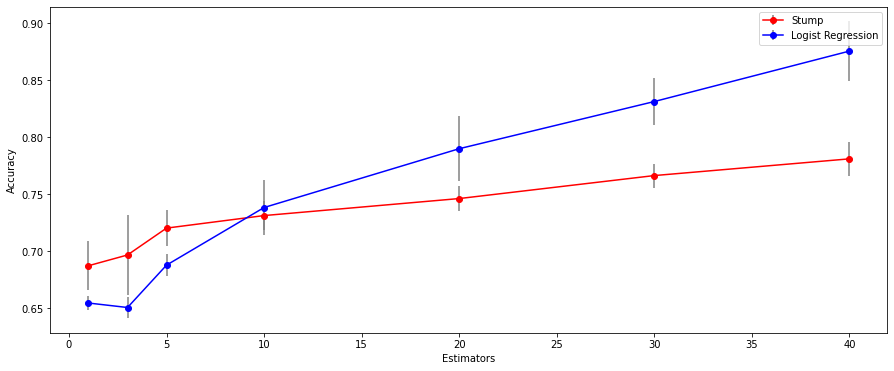

In [5]:
n_estimators_to_test = [1, 3, 5, 10, 20, 30, 40]

# Realizando o experimento para o stump
stump_accuracy = list()
stump_error = list()
for n in n_estimators_to_test:
  accuracy, error = cross_validation_score(MyAdaboostClassifier(n_estimators=n, classifier_model='stump'),
                                           features_partitions, labels_partitions)
  stump_accuracy.append(accuracy)
  stump_error.append(error)
  
# Realizando o experimento para a regressao logistica
l_regression_accuracy = list()
l_regression_error = list()
for n in n_estimators_to_test:
  accuracy, error = cross_validation_score(MyAdaboostClassifier(n_estimators=n, classifier_model='weak-logistic-regression'),
                                           features_partitions, labels_partitions)
  l_regression_accuracy.append(accuracy)
  l_regression_error.append(error)
  
# Plotando os resultados
plt.figure(figsize=(15, 6))
plt.errorbar(x=n_estimators_to_test, y=stump_accuracy, yerr=stump_error,
             fmt='-o', color='r', ecolor='gray', label='Stump')
plt.errorbar(x=n_estimators_to_test, y=l_regression_accuracy, yerr=l_regression_error,
             fmt='-o', color='b', ecolor='gray',label='Logist Regression')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Conclusion

Com os experimentos acima foi possível observar o comportamento da implementação do MyAdaboost comparado tanto com a implementação padrão do sklearn assim como com os conhecimentos teoricos discutidos em aula. Em ambas, é notório que o comportamento do MyAdaboost seguiu o que era esperado, e portanto é seguro dizer que a implentação feita foi correta.

Um ponto negativo da implementação do MyAdaboost é que ele ficou bem mais lento comparado com o Adaboost do sklearn. Porém, por outro lado, ele é capaz de aceitar diferentes classificadores fracos, o que pode ser considerado como um hyper parametro na hora de procurar o melhor classificador para um dado dataset. 

Em uma comparação final, segue abaixo a porcentagem de acertos dos Adaboost's, utilizados nos experimentos, com 100 estimadores. É interessante observar como o MyAdaboost com logistic-regression perfomou parelhamente e até um pouco melhor que o padrão do sklearn.



In [6]:
my_adaboost_lr = MyAdaboostClassifier(n_estimators=100, classifier_model='weak-logistic-regression')
my_adaboost_stump = MyAdaboostClassifier(n_estimators=100, classifier_model='stump')
sklearn_adaboost = AdaBoostClassifier(n_estimators=100)

print('{}: {} +- {}'.format('MyAdaboost (logistic-regression)', *cross_validation_score(my_adaboost_lr, features_partitions, labels_partitions)))
print('{}: {} +- {}'.format('MyAdaboost (stump)', *cross_validation_score(my_adaboost_stump, features_partitions, labels_partitions)))
print('{}: {} +- {}'.format('Sklearn Adaboost', *cross_validation_score(sklearn_adaboost, features_partitions, labels_partitions)))

MyAdaboost (logistic-regression): 0.9013089005235603 +- 0.026997639967232947
MyAdaboost (stump): 0.8628272251308902 +- 0.022631491881205244
Sklearn Adaboost: 0.8900523560209426 +- 0.0200565249312858
